In [20]:
# import required packages
from fastai2.tabular.all import *
from helpers import *

In [21]:
# path to project directory
path = Path('./')

In [30]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v4.csv', index_col=0, dtype={'season':str})

## Neural network model

Fastai have an neural network architecture that can be applied to tabular data, including for time series. In practice this creates embeddings for categorical features, combines them with continuous variables and passes this through a number of fully connected layers to produce a prediction for the dependent variable. They also include a number of tricks and default parameters that should produce decent performance.

Once again we'll first create some lag features.

In [32]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

And go ahead and create our training set.

The gameweeks and seasons are ordered, so we want to have them as ordered categories with the correct order (2016-17, 2017-18, etc.). And for this model we need to make the dependent variable a float.

In [33]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 1
valid_len = 6
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [34]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

In [35]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [36]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [37]:
# create dataset with adjusted post-validation lag numbers
lag_train_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

lag_train_df[player_lag_vars + team_lag_vars] = lag_train_df[player_lag_vars + team_lag_vars].fillna(0)

In [38]:
# take a look at the dataframe
lag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71132 entries, 0 to 71131
Data columns (total 33 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   index                                       71132 non-null  int64   
 1   was_home                                    71132 non-null  bool    
 2   position                                    71132 non-null  int64   
 3   player                                      71132 non-null  object  
 4   gw                                          71132 non-null  category
 5   opponent_team                               71132 non-null  object  
 6   team                                        71132 non-null  object  
 7   season                                      71132 non-null  category
 8   minutes                                     71132 non-null  int64   
 9   relative_market_value_team_season           71132 non-null  float64 
 10

In [39]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(67936, 71132)

In [40]:
lag_train_df[cat_vars + ['player']].nunique()

gw                 38
season              4
position            4
team               29
opponent_team      29
was_home            2
player           1211
dtype: int64

In [41]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

In [42]:
cont_vars + player_lag_vars + team_lag_vars

['minutes',
 'relative_market_value_team_season',
 'relative_market_value_opponent_team_season',
 'total_points_pg_last_all',
 'total_points_pg_last_1',
 'total_points_pg_last_2',
 'total_points_pg_last_3',
 'total_points_pg_last_4',
 'total_points_pg_last_5',
 'total_points_pg_last_10',
 'total_points_team_pg_last_all',
 'total_points_team_pg_last_1',
 'total_points_team_pg_last_2',
 'total_points_team_pg_last_3',
 'total_points_team_pg_last_4',
 'total_points_team_pg_last_5',
 'total_points_team_pg_last_10',
 'total_points_team_pg_last_all_opponent',
 'total_points_team_pg_last_1_opponent',
 'total_points_team_pg_last_2_opponent',
 'total_points_team_pg_last_3_opponent',
 'total_points_team_pg_last_4_opponent',
 'total_points_team_pg_last_5_opponent',
 'total_points_team_pg_last_10_opponent']

In [43]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(lag_train_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

In [44]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [45]:
dls.show_batch()

In [46]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

In [49]:
learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0008317637839354575)

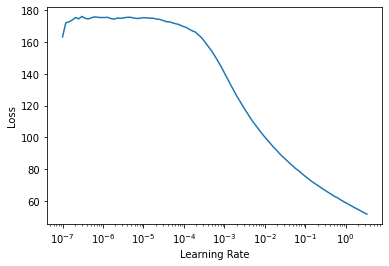

In [108]:
learn.lr_find()

In [50]:
# seems to work ok without the lag vars
learn.fit_one_cycle(10, 1e-2, wd=0.2)

In [173]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

1.931613

In [174]:
targs_no_zero = targs[(lag_train_df.iloc[valid_idx]['minutes'] > 0).to_numpy()]

In [175]:
preds_no_zero = preds[(lag_train_df.iloc[valid_idx]['minutes'] > 0).to_numpy()]

In [176]:
r_mse(preds_no_zero,targs_no_zero)

2.677255

In [177]:
# for loop to run through a season long validation

# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

season_rsme = []

for valid_gw in range(1,34): 
    
    lag_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                    cat_vars, cont_vars, 
                                                    player_lag_vars, team_lag_vars, dep_var,
                                                    valid_season, valid_gw, valid_len)
    
    X, y = lag_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), lag_df[dep_var].copy()
    
    # create train/valid splits
    splits = (list(train_idx), list(valid_idx))
    
    # processors - categorify categorical variables and normalize continuous variables
    # fill missing not used because new teams are almost certainly well below the league average
    procs=[Categorify, Normalize]
    to_nn = TabularPandas(lag_train_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                          splits=splits, y_names=dep_var)
    
    dls = to_nn.dataloaders()
    
    learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)
    
    # seems to work ok without the lag vars
    learn.fit_one_cycle(7, 1e-2, wd=0.2)
    
    preds,targs = learn.get_preds()
    gw_rsme = r_mse(preds,targs)
    
    print("GW%d RMSE: %f" % (valid_gw, gw_rsme))
    
    season_rsme.append(gw_rsme)

GW1 RMSE: 1.934471


GW2 RMSE: 1.874481


GW3 RMSE: 1.937269


GW4 RMSE: 1.911622


GW5 RMSE: 1.982166


GW6 RMSE: 2.027352


GW7 RMSE: 1.916805


GW8 RMSE: 1.948164


GW9 RMSE: 1.924063


GW10 RMSE: 1.945478


GW11 RMSE: 1.900353


GW12 RMSE: 1.850525


GW13 RMSE: 1.888461


GW14 RMSE: 1.888086


GW15 RMSE: 1.821179


GW16 RMSE: 1.839024


GW17 RMSE: 1.819358


GW18 RMSE: 1.810203


GW19 RMSE: 1.802624


GW20 RMSE: 1.803309


GW21 RMSE: 1.838577


GW22 RMSE: 1.807919


GW23 RMSE: 1.841874


GW24 RMSE: 1.852484


GW25 RMSE: 1.842851


GW26 RMSE: 1.794709


GW27 RMSE: 1.827510


GW28 RMSE: 1.837564


GW29 RMSE: 1.776864


GW30 RMSE: 1.843211


GW31 RMSE: 1.769879


GW32 RMSE: 1.786533


GW33 RMSE: 1.739915


In [178]:
season_rsme

[1.934471,
 1.874481,
 1.937269,
 1.911622,
 1.982166,
 2.027352,
 1.916805,
 1.948164,
 1.924063,
 1.945478,
 1.900353,
 1.850525,
 1.888461,
 1.888086,
 1.821179,
 1.839024,
 1.819358,
 1.810203,
 1.802624,
 1.803309,
 1.838577,
 1.807919,
 1.841874,
 1.852484,
 1.842851,
 1.794709,
 1.82751,
 1.837564,
 1.776864,
 1.843211,
 1.769879,
 1.786533,
 1.739915]

In [179]:
np.mean(season_rsme)

1.8601479696969698

In [109]:
# learn.fit_one_cycle(10, 1e-2, wd=0.2)

In [10]:
# find validation cut point - index for 19-20 season second half (gw 19)
valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1920')].index.min()
valid_end = train_df.index.max()

In [44]:
# set validation dataset based on indexes
train_idx = range(valid_start)
valid_idx = range(valid_start, valid_end)

splits = (list(train_idx), list(valid_idx))
valid_idx

range(77810, 90436)

In [12]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [13]:
# set dependent variable
dep_var = 'total_points'

In [14]:
train_df[cat_vars].nunique()

player           1306
gw                 38
position            4
team               29
opponent_team      29
was_home            2
season              4
dtype: int64

In [15]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_df, procs, cat_vars, cont_vars,
                      splits=splits, y_names=dep_var)

In [39]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [22]:
dls.show_batch()

In [18]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = (-1, max_y)

In [54]:
learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0012022644514217973)

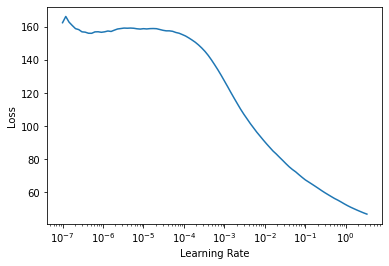

In [48]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

In [25]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [57]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

1.807521

In [27]:
preds

tensor([[-0.0926],
        [ 0.2595],
        [-0.1763],
        ...,
        [-0.2005],
        [ 5.2565],
        [-0.1782]])

In [28]:
targs

tensor([[-3.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 3.],
        [ 0.]])